# Problem A 
# 0. Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Data Processing
通过阅读论文我们可以发现，每一个基站记录的信号数据中，RSSI的值是最有意义的，因而我们对每个基站的`feature`选取为：

|栅格x|栅格y|RSSI|
|---|---|---|
|经度栅格化的坐标|维度栅格化的坐标|信号强度|

每一条MR记录有7个基站，再加上连接的基站数`Num_connected`，因而有`3 * 7 + 1 = 22`个feature。


## 1.1 Cleaning
首先将数据读入，由于每一条MR记录中，七个基站的数据存在缺失以及数据有误的情况，因而需要对数据做一个清洗，清洗的内容包括：
- 补全缺失值
- 对无法定位的基站将数据重置

补全与重置的值主要是针对`RSSI`的值作替换。
> RSSI(Received Signal Strength Indication)表示接收的信号强度指示，无线发送层的可选部分，用来判定链接质量，以及是否增大广播发送强度。
$$RSSI(dbm)=10log_{10}P(mw)$$
查看RSSI的平均值是判断干扰的重要手段，空载下RSSI值一般在-110dBm左右。

> dbm值只在一种情况下为0，那就是在理想状态下经过实验测量的结果，一般我们认为dbm为0是其最大值，意味着接收方把发射方发射的所有无线信号都接收到了，即无线路由器发射多少功率，接收的无线网卡就获得多少功率。当然这是在理想状态下测量的，在实际中即使将无线网卡挨着无线路由器的发射天线也不会达到dbm为0的效果。所以说测量出来的dbm值都是负数，不要盲目的认为负数就是信号不好。

也就是说，信号越强，`RSSI`越高，但是通常都小于$0$，同时通过对数据的排序统计，可以发现数据中`RSSI`最小为$-109$，这也印证了上述说法。因而我们统一将缺失值和设定值设为$-110$。


In [3]:
raw_data = pd.read_csv('../../../data/data_2g.csv')
raw_data = raw_data.fillna(-110)  # missing value 

# type conversion
raw_data['IMSI']= raw_data['IMSI'].astype('int')
raw_data['MRTime']= raw_data['MRTime'].astype('int')
for i in range(1, 8):
    raw_data[f'RNCID_{i}'] = raw_data[f'RNCID_{i}'].astype('int')
    raw_data[f'CellID_{i}'] = raw_data[f'CellID_{i}'].astype('int')
    raw_data[f'AsuLevel_{i}'] = raw_data[f'AsuLevel_{i}'].astype('int')
    raw_data[f'SignalLevel_{i}'] = raw_data[f'SignalLevel_{i}'].astype('int')
    raw_data[f'RSSI_{i}'] = raw_data[f'RSSI_{i}'].astype('int')

# station data
station_data = pd.read_csv('../../../data/2g_gongcan.csv')
station_data['RNCID'] = station_data['RNCID'].astype(int)
station_data['CellID'] = station_data['CellID'].astype(int)
    
raw_data[['Longitude', 'Latitude']].describe()

,Longitude,Latitude
count,6096.000000,6096.000000
mean,121.211083,31.287630
std,0.003465,0.003145
min,121.201205,31.281757
25%,121.209179,31.284902
50%,121.212079,31.287601
75%,121.213316,31.289905
max,121.218329,31.293393


事实上，数据中只包含3位用户，将用户的`IMSI`替换成整数`1, 2, 3`。

In [4]:
imsi_dict = {}
for i, key in enumerate(set(list(raw_data['IMSI']))):
    imsi_dict[key] = i + 1

def replace_IMSI(imsi):
    return imsi_dict[imsi]
func_IMSI = np.vectorize(replace_IMSI)
raw_data['IMSI'] = func_IMSI(raw_data['IMSI'])

## 1.2 Rasterize

第二步，将经纬度转化为距离，再栅格化为坐标`(x, y)`,从`0`开始标号，每20m为一个单位；同时为每个格子赋予一个`caster_id`，计算方式为`id = y * cols + x`。

In [5]:
from haversine import haversine
import math

LONGITUDE_RANGE = [121.20120490000001, 121.2183295]
LATITUDE_RANGE = [31.28175691, 31.29339344]
CASTER_UNIT = 20 # meter
dist_X = haversine((LATITUDE_RANGE[0], LONGITUDE_RANGE[0]), (LATITUDE_RANGE[0], LONGITUDE_RANGE[1])) # in kilometers
dist_Y = haversine((LATITUDE_RANGE[0], LONGITUDE_RANGE[0]), (LATITUDE_RANGE[1], LONGITUDE_RANGE[0])) # in kilometers

caster_num_x = int(np.ceil(dist_X * 1000 / CASTER_UNIT))
caster_num_y = int(np.ceil(dist_Y * 1000 / CASTER_UNIT))
print('The x-caster number:', caster_num_x)
print('The y-caster number:', caster_num_y)

STRIDE_X = (LONGITUDE_RANGE[1] - LONGITUDE_RANGE[0]) / caster_num_x
STRIDE_Y = (LATITUDE_RANGE[1] - LATITUDE_RANGE[0]) / caster_num_y
print('The stride length for longtitude =', STRIDE_X)
print('The stride length for latitude =', STRIDE_Y)

The x-caster number: 82
The y-caster number: 65
The stride length for longtitude = 0.0002088365853657107
The stride length for latitude = 0.00017902353846154667


In [12]:
def coordinate_to_raster(longitude, latitude):
    x = math.floor((longitude - LONGITUDE_RANGE[0]) / STRIDE_X)
    y = math.floor((latitude - LATITUDE_RANGE[0]) / STRIDE_Y)
    raster = int(y * caster_num_x + x)
    return raster

#def raster_to_cordinate(raster):
    
def raster_to_longitude(raster):
    x = raster % caster_num_x
    lon = LONGITUDE_RANGE[0] + (x + 0.5) * STRIDE_X
    return lon #raster_to_cordinate(raster)[0]
    
def raster_to_latitude(raster):
    y = raster // caster_num_x
    lat = LATITUDE_RANGE[0] +  (y + 0.5) * STRIDE_Y
    return lat #raster_to_cordinate(raster)[1]
    
func_c2r = np.vectorize(coordinate_to_raster) # the Generalized function
raw_data['raster'] = func_c2r(raw_data['Longitude'], raw_data['Latitude'])
func_r2lon = np.vectorize(raster_to_longitude)
func_r2lat = np.vectorize(raster_to_latitude)
raw_data['r_longitude'] = func_r2lon(raw_data['raster'])
raw_data['r_latitude'] = func_r2lat(raw_data['raster'])

In [19]:
raw_data.dtypes

IMSI               int64
MRTime             int64
Longitude        float64
Latitude         float64
Num_connected      int64
RNCID_1            int64
CellID_1           int64
AsuLevel_1         int64
SignalLevel_1      int64
RSSI_1             int64
RNCID_2            int64
CellID_2           int64
AsuLevel_2         int64
SignalLevel_2      int64
RSSI_2             int64
RNCID_3            int64
CellID_3           int64
AsuLevel_3         int64
SignalLevel_3      int64
RSSI_3             int64
RNCID_4            int64
CellID_4           int64
AsuLevel_4         int64
SignalLevel_4      int64
RSSI_4             int64
RNCID_5            int64
CellID_5           int64
AsuLevel_5         int64
SignalLevel_5      int64
RSSI_5             int64
RNCID_6            int64
CellID_6           int64
AsuLevel_6         int64
SignalLevel_6      int64
RSSI_6             int64
RNCID_7            int64
CellID_7           int64
AsuLevel_7         int64
SignalLevel_7      int64
RSSI_7             int64


### Plot the results

栅格的画线单位是基于 `range / num` 来重新划分的，而并非是 $20m$ 的换算值。
分别画出：
1. 点在地图上的精确位置
2. 栅格化的中心位置

In [7]:
def draw_BG_line():
    # draw the vertical line
    x = LONGITUDE_RANGE[0]
    for i in range(caster_num_x):
        x += STRIDE_X
        plt.vlines(x, ymin=LATITUDE_RANGE[0], ymax=LATITUDE_RANGE[1], color='orange', linewidth=0.5, alpha=0.4)
    
    # draw the horizontal line
    y = LATITUDE_RANGE[0]
    for i in range(caster_num_y):
        y += STRIDE_Y
        plt.hlines(y, xmin=LONGITUDE_RANGE[0], xmax=LONGITUDE_RANGE[1], color='orange', linewidth=0.5, alpha=0.4)

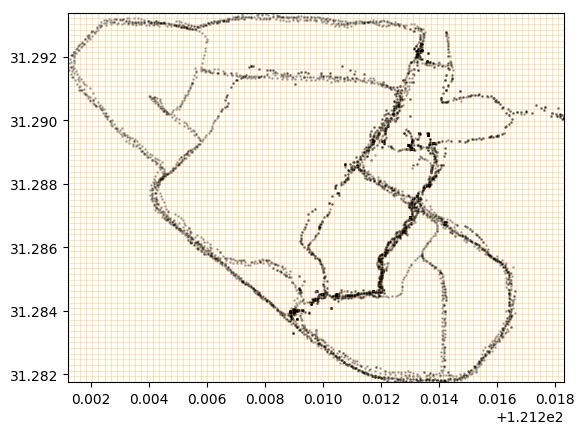

In [8]:
plt.style.use('default')
plt.scatter(raw_data['Longitude'], raw_data['Latitude'], color='black', s=1, alpha=0.25)

plt.xlim(LONGITUDE_RANGE)
plt.ylim(LATITUDE_RANGE)

draw_BG_line()

plt.savefig('scatter.pdf')

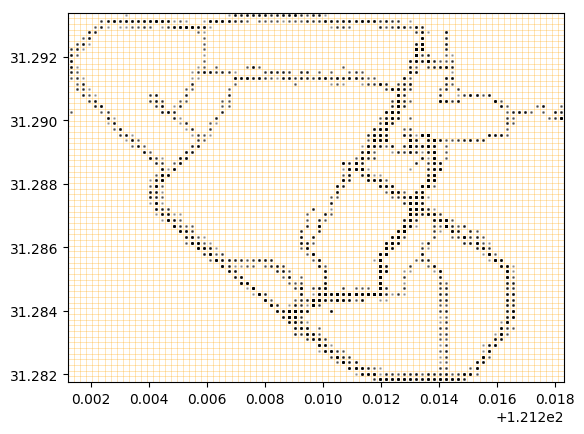

In [9]:
plt.style.use('default')
plt.scatter(raw_data['r_longitude'], raw_data['r_latitude'], color='black', s=1, alpha=0.25)

plt.xlim(LONGITUDE_RANGE)
plt.ylim(LATITUDE_RANGE)

draw_BG_line()

plt.savefig('scatter_scatter.pdf')

## 1.3 Pick up the features
选取的特征包括 `有效连接的基站数`，`7个基站的经纬度及相应的RSSI值`，共`22`个特征。
其中对于无效经纬度用`-1`来取代。

In [10]:
feature_column = ['Num_connected']
for i in range(1, 8):
    feature_column.append(f'RNCID_{i}')
    feature_column.append(f'CellID_{i}')
    feature_column.append(f'RSSI_{i}')
X = raw_data[feature_column]

for i in range(1, 8):
    X = pd.merge(X, station_data, how='left',
                 left_on=[f'RNCID_{i}', f'CellID_{i}'],
                 right_on=['RNCID', 'CellID'])
    X = X.rename(index=str,
                 columns={'Longitude': f'Longitude_{i}', 'Latitude': f'Latitude_{i}'})
    X = X.drop(columns=['RNCID', 'CellID', f'RNCID_{i}', f'CellID_{i}'])
X = X.fillna(-1)
Y = raw_data[['Longitude', 'Latitude', 'raster']]
X.describe()

,Num_connected,RSSI_1,RSSI_2,RSSI_3,RSSI_4,RSSI_5,RSSI_6,RSSI_7,Latitude_1,Longitude_1,...,Latitude_3,Longitude_3,Latitude_4,Longitude_4,Latitude_5,Longitude_5,Latitude_6,Longitude_6,Latitude_7,Longitude_7
count,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,...,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000
mean,6.076608,-66.404528,-77.094816,-78.203412,-79.323655,-80.711614,-86.018373,-98.022966,31.285421,121.212816,...,28.712739,111.470898,26.239578,102.107259,23.369133,91.241493,18.140909,71.454001,7.670305,31.818701
std,1.067779,10.650526,9.612861,9.586990,10.387192,11.915074,15.126375,15.141676,0.007005,0.005475,...,8.746114,33.106443,11.726657,44.387743,13.892174,52.584341,15.863719,60.048867,14.310816,54.169073
min,2.000000,-109.000000,-109.000000,-110.000000,-110.000000,-110.000000,-110.000000,-110.000000,31.257603,121.191709,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,6.000000,-75.000000,-83.000000,-83.000000,-85.000000,-85.000000,-95.000000,-110.000000,31.281802,121.208284,...,31.280800,121.208105,31.280800,121.208105,31.270705,121.191709,-1.000000,-1.000000,-1.000000,-1.000000
50%,6.000000,-67.000000,-77.000000,-77.000000,-79.000000,-79.000000,-83.000000,-110.000000,31.288649,121.211928,...,31.288649,121.210909,31.288649,121.209767,31.287199,121.208284,31.280418,121.208105,-1.000000,-1.000000
75%,7.000000,-57.000000,-71.000000,-73.000000,-73.000000,-73.000000,-77.000000,-83.000000,31.289402,121.218285,...,31.289647,121.217871,31.289402,121.217871,31.289402,121.217871,31.289351,121.212407,31.276852,121.205655
max,7.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,31.295884,121.224621,...,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990


In [11]:
Y.describe()

,Longitude,Latitude,raster
count,6096.000000,6096.000000,6096.000000
mean,121.211083,31.287630,2697.061516
std,0.003465,0.003145,1437.548977
min,121.201205,31.281757,50.000000
25%,121.209179,31.284902,1445.000000
50%,121.212079,31.287601,2681.000000
75%,121.213316,31.289905,3742.000000
max,121.218329,31.293393,5363.000000


# 2. Training and Classification
随机选取 $80\% $的数据记录作为训练集，余下 $20\% $作为测试集合，计算预测位置和证实位置的误差（采用欧式距离），按照计算误差从小到大进行排序。

重复 $10$ 次训练集/测试集的选择和误差计算，求平均误差，绘制平均误差概率分布图，其中`x-轴`为排序编号，`y-轴`为对应的平均误差，中位误差为`x-轴` $50\%$ 排序编号的`y轴`对应平均误差。

对每个分类器在测试集上的结果，计算`precision`，`recall`和`f-measurement`来评价分类器的好坏。

## 2.1 选取模型
按照作业要求，共使用以下七个模型

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {
    'Naive-Bayes': GaussianNB(),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision-Tree': DecisionTreeClassifier(criterion='entropy', max_depth=50),
    'Random-Forest': RandomForestClassifier(max_features=3, n_estimators=45),
    'Bagging': BaggingClassifier(n_estimators=40),
    'AdaBoost': AdaBoostClassifier(n_estimators=150, learning_rate=0.1),
    'Gradient-Boosting': GradientBoostingClassifier(max_depth=10, n_estimators=40),
}

model_error = {}
model_para = {
    'prec-overall': [],
    'prec-grid': [],
    'recall': [],
    'f': []
}

## 2.2 模型训练

使用7个模型，依次训练10个`round`，每个`round`随机划分训练集、测试集，计算`precision_overall`,`precision_grid`,`recall_grid`和`f_measurement`，对10次结果取平均结果。
注：使用`recall_score`和`precision_score`时，利用`average='macro'`即可计算得到全局的准确率和召回率，而`average='micro'`则会根据每一个`grid`来计算局部准确率和召回率，自动计算每个`grid`的平均值。


In [28]:
def calculate_dist(test_lon, test_lat, pred_lon, pred_lat):
    return haversine((test_lat, test_lon), (pred_lat, pred_lon))

func_dist = np.vectorize(calculate_dist)

In [74]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score

for clf_name, clf in models.items():
    print('=' * 50)
    print('Classification :', clf_name)
    print('=' * 50)
    precision_overall = 0
    precision_grid = 0
    recall = 0
    Y_distance = 0
    round_count = 10
    down_sampling_count = 10 # down sampling for the CDF-plot
    error = np.zeros(down_sampling_count)
    for i in range(round_count):
        # partition the training and testing data randomly 
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        
        # fit and predict
        time_start = time.time()
        clf.fit(X_train, Y_train['raster'])
        Y_predict = clf.predict(X_test)
        time_end = time.time()
        
        # calculate the presicion, recall and f-measurement
        # average='micro' -> Calculate metrics globally by counting the total true positives, false negatives and false positives.
        # average='macro' -> Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        round_pre_overall = precision_score(Y_test['raster'], Y_predict, average='micro')
        round_pre_grid = precision_score(Y_test['raster'], Y_predict, average='macro')
        round_recall = recall_score(Y_test['raster'], Y_predict, average='macro')
        round_f = 2 * (round_pre_grid * round_recall) / (round_pre_grid + round_recall)
        
        print(f'(Round {i}) '
              f'P_O: {round_pre_overall * 100:.2f}%, '
              f'P_G: {round_pre_grid * 100:.2f}%, '
              f'R: {round_recall * 100:.2f}%, '
              f'F: {round_f * 100:.2f}%'
              f' ({time_end - time_start:.2f}s)')
        
        # accumulate the measurements
        precision_overall += round_pre_overall
        precision_grid += round_pre_grid
        recall += round_recall
        
        # convert the raster to longitude and latitude
        Y_predict_lon = func_r2lon(Y_predict)
        Y_predict_lat = func_r2lat(Y_predict)
        # calculate the distance
        Y_distance = func_dist(Y_test['Longitude'], Y_test['Latitude'], Y_predict_lon, Y_predict_lat)
        Y_distance *= 1000  # unit: meters
        Y_distance = np.sort(Y_distance)
        down_samples = np.linspace(0, len(Y_distance) - 1, down_sampling_count, dtype=int)
        error += np.asarray(Y_distance.take(down_samples))
    
    error /= round_count # average error
    
    # the overall measurement
    precision_overall /= round_count
    precision_grid /= round_count
    recall /= round_count
    f_measurement = 2 * (precision_grid * recall) / (precision_grid + recall)
    
    print(f'(Overall) '
          f'P_O: {precision_overall * 100:.2f}%, '
          f'P_G: {precision_grid * 100:.2f}%, '
          f'R: {recall * 100:.2f}%, '
          f'F: {f_measurement * 100:.2f}%')
    
    # the model error
    model_error[clf_name] = error
    model_para['prec-overall'].append(precision_overall)
    model_para['prec-grid'].append(precision_grid)
    model_para['recall'].append(recall)
    model_para['f'].append(f_measurement)

Classification : Naive-Bayes


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 0) P_O: 9.51%, P_G: 8.20%, R: 10.40%, F: 9.17% (0.32s)
(Round 1) P_O: 9.10%, P_G: 9.05%, R: 10.44%, F: 9.69% (0.58s)
(Round 2) P_O: 11.07%, P_G: 9.60%, R: 12.16%, F: 10.73% (0.68s)
(Round 3) P_O: 11.56%, P_G: 10.35%, R: 12.22%, F: 11.21% (0.52s)
(Round 4) P_O: 8.77%, P_G: 8.10%, R: 10.12%, F: 9.00% (0.32s)
(Round 5) P_O: 10.90%, P_G: 8.83%, R: 12.29%, F: 10.28% (0.40s)
(Round 6) P_O: 10.82%, P_G: 10.67%, R: 12.11%, F: 11.34% (0.38s)
(Round 7) P_O: 10.57%, P_G: 8.39%, R: 10.55%, F: 9.35% (0.38s)
(Round 8) P_O: 10.90%, P_G: 8.07%, R: 11.24%, F: 9.39% (0.51s)
(Round 9) P_O: 12.13%, P_G: 9.27%, R: 11.22%, F: 10.16% (0.64s)
(Overall) P_O: 10.53%, P_G: 9.05%, R: 11.27%, F: 10.04%
Classification : K-Neighbors
(Round 0) P_O: 29.02%, P_G: 12.02%, R: 15.68%, F: 13.61% (0.43s)
(Round 1) P_O: 29.92%, P_G: 13.48%, R: 15.67%, F: 14.50% (0.20s)
(Round 2) P_O: 29.75%, P_G: 13.44%, R: 15.72%, F: 14.49% (0.23s)
(Round 3) P_O: 30.57%, P_G: 12.86%, R: 15.05%, F: 13.87% (0.23s)
(Round 4) P_O: 25.98%

/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 0) P_O: 50.25%, P_G: 30.43%, R: 31.37%, F: 30.89% (6.30s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 1) P_O: 50.16%, P_G: 30.47%, R: 31.66%, F: 31.06% (6.91s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 2) P_O: 52.79%, P_G: 32.74%, R: 33.44%, F: 33.09% (7.03s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 3) P_O: 50.08%, P_G: 28.95%, R: 29.50%, F: 29.22% (6.94s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 4) P_O: 48.93%, P_G: 28.95%, R: 30.79%, F: 29.84% (5.55s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 5) P_O: 48.03%, P_G: 29.18%, R: 30.89%, F: 30.01% (6.99s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 6) P_O: 47.38%, P_G: 28.46%, R: 29.97%, F: 29.19% (5.24s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 7) P_O: 49.43%, P_G: 31.20%, R: 32.31%, F: 31.74% (5.26s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 8) P_O: 48.20%, P_G: 30.71%, R: 31.63%, F: 31.17% (5.04s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 9) P_O: 47.38%, P_G: 26.20%, R: 28.23%, F: 27.18% (5.06s)
(Overall) P_O: 49.26%, P_G: 29.73%, R: 30.98%, F: 30.34%
Classification : Bagging


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 0) P_O: 47.70%, P_G: 27.18%, R: 29.20%, F: 28.15% (9.63s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 1) P_O: 48.85%, P_G: 29.07%, R: 31.41%, F: 30.19% (9.01s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 2) P_O: 48.11%, P_G: 28.91%, R: 30.66%, F: 29.76% (9.61s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 3) P_O: 52.13%, P_G: 31.41%, R: 32.58%, F: 31.99% (9.28s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 4) P_O: 49.92%, P_G: 30.47%, R: 31.16%, F: 30.81% (8.87s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 5) P_O: 49.92%, P_G: 30.31%, R: 31.63%, F: 30.96% (8.42s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 6) P_O: 49.67%, P_G: 28.16%, R: 28.58%, F: 28.37% (8.93s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 7) P_O: 46.39%, P_G: 27.09%, R: 28.35%, F: 27.70% (8.74s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 8) P_O: 49.43%, P_G: 31.98%, R: 32.89%, F: 32.43% (8.67s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 9) P_O: 51.48%, P_G: 32.19%, R: 33.13%, F: 32.65% (8.88s)
(Overall) P_O: 49.36%, P_G: 29.68%, R: 30.96%, F: 30.30%
Classification : AdaBoost


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 0) P_O: 9.51%, P_G: 1.57%, R: 2.36%, F: 1.88% (25.87s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 1) P_O: 11.48%, P_G: 3.31%, R: 4.14%, F: 3.68% (25.89s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 2) P_O: 12.95%, P_G: 3.27%, R: 4.02%, F: 3.60% (26.75s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 3) P_O: 13.28%, P_G: 2.96%, R: 4.35%, F: 3.52% (25.56s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 4) P_O: 12.46%, P_G: 2.92%, R: 3.50%, F: 3.18% (28.76s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 5) P_O: 9.92%, P_G: 2.15%, R: 2.79%, F: 2.43% (27.37s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 6) P_O: 12.79%, P_G: 2.58%, R: 5.01%, F: 3.41% (28.39s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 7) P_O: 12.13%, P_G: 1.99%, R: 3.12%, F: 2.43% (29.75s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 8) P_O: 10.25%, P_G: 1.97%, R: 3.02%, F: 2.38% (24.23s)


/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(Round 9) P_O: 11.72%, P_G: 2.92%, R: 4.30%, F: 3.48% (24.53s)
(Overall) P_O: 11.65%, P_G: 2.56%, R: 3.66%, F: 3.02%
Classification : Gradient-Boosting


KeyboardInterrupt: 

In [53]:
import pickle
# with open('model_error.pkl', 'wb') as f:
#     pickle.dump(model_error, f)
with open('model_error.pkl', 'rb') as f:
    model_error = pickle.load(f)
print(model_error)
model_error.keys()

{'Naive-Bayes': array([6.56936374e-01, 1.27450095e+01, 2.66172358e+01, 6.90972873e+01,
       1.76102331e+02, 2.91702667e+02, 4.26628028e+02, 5.73363040e+02,
       7.89012178e+02, 1.44591087e+03]), 'K-Neighbors': array([5.57703078e-01, 5.66842627e+00, 8.98545116e+00, 1.34927307e+01,
       2.11068063e+01, 3.89200880e+01, 1.56294528e+02, 4.46138557e+02,
       7.52845147e+02, 1.63907569e+03]), 'Decision-Tree': array([6.18569558e-01, 5.43496634e+00, 7.00190990e+00, 8.96360544e+00,
       1.11925382e+01, 1.43675540e+01, 1.83685357e+01, 2.53917994e+01,
       5.87795320e+01, 1.16475267e+03]), 'Random-Forest': array([5.39371713e-01, 5.39031945e+00, 6.70145885e+00, 8.61177390e+00,
       1.04232382e+01, 1.29091691e+01, 1.60247809e+01, 2.03495524e+01,
       2.94005348e+01, 1.15697619e+03]), 'Bagging': array([5.12947186e-01, 5.35781189e+00, 6.65237194e+00, 8.55376946e+00,
       1.03660200e+01, 1.29103254e+01, 1.60809704e+01, 2.06482408e+01,
       3.06382292e+01, 1.11526624e+03]), 'AdaBoost

dict_keys(['Naive-Bayes', 'K-Neighbors', 'Decision-Tree', 'Random-Forest', 'Bagging', 'AdaBoost', 'Gradient-Boosting'])

## 2.3 结果图表
1. 平均误差概率分布图
2. 各模型的`precision, recall, f-measurement`

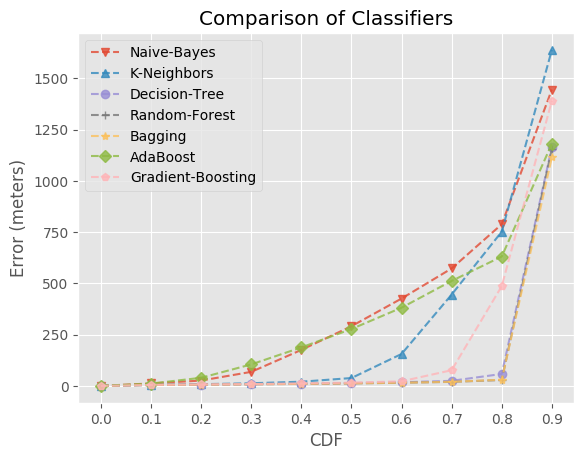

In [54]:
plt.style.use('ggplot')
#model_error['Gradient-Boosting'] = np.zeros(10)
markers = ['v', '^', 'o', '+', '*', 'D', 'p', 's', 'x']

xticks = np.arange(0, 1, 1 / down_sampling_count)
plt.xticks(xticks)
for clf_name, marker in zip(model_error.keys(), markers):
    plt.plot(xticks, model_error[clf_name],
             linestyle='--', marker=marker, alpha=0.8)
    
plt.title('Comparison of Classifiers')
plt.xlabel('CDF')
plt.ylabel('Error (meters)')
plt.legend(models.keys())
plt.savefig('classifiers_comparison.pdf')

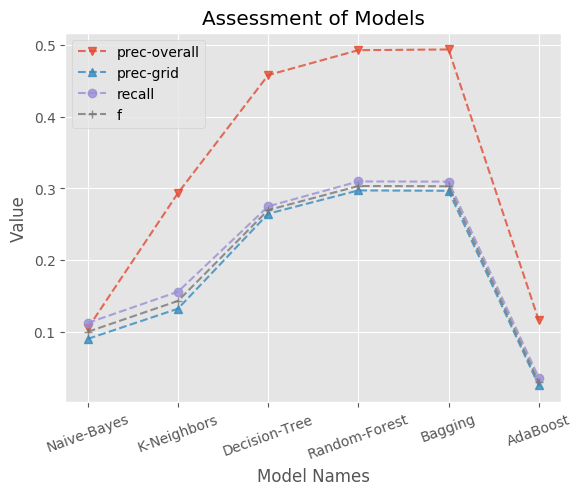

In [83]:
plt.style.use('ggplot')
xticks = np.arange(len(para_value))
plt.xticks(xticks, models.keys(), rotation=20)

for (para, para_value), marker in zip(model_para.items(), markers):
    plt.plot(xticks, para_value,
             linestyle='--', marker=marker, alpha=0.8)

plt.title('Assessment of Models')
plt.xlabel('Model Names')
plt.ylabel('Value')
plt.legend(model_para.keys())
plt.savefig('Assessment_of_Models.pdf')

# 3. 结果分析

In [21]:
Y.describe()

,Longitude,Latitude,raster,RNCID,CellID
count,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000
mean,121.211083,31.287630,2697.061516,5992.683071,30131.935039
std,0.003465,0.003145,1437.548977,393.055613,8669.766404
min,121.201205,31.281757,50.000000,5198.000000,13394.000000
25%,121.209179,31.284902,1445.000000,6182.000000,25312.000000
50%,121.212079,31.287601,2681.000000,6188.000000,27378.000000
75%,121.213316,31.289905,3742.000000,6188.000000,41123.000000
max,121.218329,31.293393,5363.000000,6188.000000,44772.000000


In [22]:
X.describe()

,Num_connected,RSSI_1,RSSI_2,RSSI_3,RSSI_4,RSSI_5,RSSI_6,RSSI_7,Latitude_1,Longitude_1,...,Latitude_3,Longitude_3,Latitude_4,Longitude_4,Latitude_5,Longitude_5,Latitude_6,Longitude_6,Latitude_7,Longitude_7
count,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,...,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000
mean,6.076608,-66.404528,-77.094816,-78.203412,-79.323655,-80.711614,-86.018373,-98.022966,31.285421,121.212816,...,28.712739,111.470898,26.239578,102.107259,23.369133,91.241493,18.140909,71.454001,7.670305,31.818701
std,1.067779,10.650526,9.612861,9.586990,10.387192,11.915074,15.126375,15.141676,0.007005,0.005475,...,8.746114,33.106443,11.726657,44.387743,13.892174,52.584341,15.863719,60.048867,14.310816,54.169073
min,2.000000,-109.000000,-109.000000,-110.000000,-110.000000,-110.000000,-110.000000,-110.000000,31.257603,121.191709,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,6.000000,-75.000000,-83.000000,-83.000000,-85.000000,-85.000000,-95.000000,-110.000000,31.281802,121.208284,...,31.280800,121.208105,31.280800,121.208105,31.270705,121.191709,-1.000000,-1.000000,-1.000000,-1.000000
50%,6.000000,-67.000000,-77.000000,-77.000000,-79.000000,-79.000000,-83.000000,-110.000000,31.288649,121.211928,...,31.288649,121.210909,31.288649,121.209767,31.287199,121.208284,31.280418,121.208105,-1.000000,-1.000000
75%,7.000000,-57.000000,-71.000000,-73.000000,-73.000000,-73.000000,-77.000000,-83.000000,31.289402,121.218285,...,31.289647,121.217871,31.289402,121.217871,31.289402,121.217871,31.289351,121.212407,31.276852,121.205655
max,7.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,31.295884,121.224621,...,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990


# Problem C

# 1. 处理数据
1. 将训练的输入数据 `X` 的第一个基站数据删去
2. 将输出数据 `Y` ，加上第一个基站对应的经纬度，并计算得到真实经纬度与基站经纬度的相对值，用作回归的目标。

In [23]:
# retrive the base data to form the new_Y results
station_data = station_data.rename(index=str, columns={'Longitude': 'base_longitude', 'Latitude': 'base_latitude'})
Y.loc[:, 'RNCID'] = raw_data['RNCID_1']
Y.loc[:, 'CellID'] = raw_data['CellID_1']
new_Y = pd.merge(Y, station_data, how='left',
                 left_on=['RNCID', 'CellID'],
                 right_on=['RNCID', 'CellID'])

new_Y['delta_x'] = new_Y['Longitude'] - new_Y['base_longitude']
new_Y['delta_y'] = new_Y['Latitude'] - new_Y['base_latitude']
new_X = X.drop(columns=['Latitude_1', 'Longitude_1'])

/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
new_X.describe()

,Num_connected,RSSI_1,RSSI_2,RSSI_3,RSSI_4,RSSI_5,RSSI_6,RSSI_7,Latitude_2,Longitude_2,Latitude_3,Longitude_3,Latitude_4,Longitude_4,Latitude_5,Longitude_5,Latitude_6,Longitude_6,Latitude_7,Longitude_7
count,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000
mean,6.076608,-66.404528,-77.094816,-78.203412,-79.323655,-80.711614,-86.018373,-98.022966,30.704330,119.008101,28.712739,111.470898,26.239578,102.107259,23.369133,91.241493,18.140909,71.454001,7.670305,31.818701
std,1.067779,10.650526,9.612861,9.586990,10.387192,11.915074,15.126375,15.141676,4.298160,16.269500,8.746114,33.106443,11.726657,44.387743,13.892174,52.584341,15.863719,60.048867,14.310816,54.169073
min,2.000000,-109.000000,-109.000000,-110.000000,-110.000000,-110.000000,-110.000000,-110.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,6.000000,-75.000000,-83.000000,-83.000000,-85.000000,-85.000000,-95.000000,-110.000000,31.281873,121.208284,31.280800,121.208105,31.280800,121.208105,31.270705,121.191709,-1.000000,-1.000000,-1.000000,-1.000000
50%,6.000000,-67.000000,-77.000000,-77.000000,-79.000000,-79.000000,-83.000000,-110.000000,31.288788,121.212896,31.288649,121.210909,31.288649,121.209767,31.287199,121.208284,31.280418,121.208105,-1.000000,-1.000000
75%,7.000000,-57.000000,-71.000000,-73.000000,-73.000000,-73.000000,-77.000000,-83.000000,31.289647,121.218285,31.289647,121.217871,31.289402,121.217871,31.289402,121.217871,31.289351,121.212407,31.276852,121.205655
max,7.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,-51.000000,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990,31.306504,121.295990


In [25]:
new_Y.describe()

,Longitude,Latitude,raster,RNCID,CellID,base_latitude,base_longitude,delta_x,delta_y
count,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000,6096.000000
mean,121.211083,31.287630,2697.061516,5992.683071,30131.935039,31.285421,121.212816,-0.001733,0.002209
std,0.003465,0.003145,1437.548977,393.055613,8669.766404,0.007005,0.005475,0.004767,0.006425
min,121.201205,31.281757,50.000000,5198.000000,13394.000000,31.257603,121.191709,-0.013210,-0.009616
25%,121.209179,31.284902,1445.000000,6182.000000,25312.000000,31.281802,121.208284,-0.005395,-0.001351
50%,121.212079,31.287601,2681.000000,6188.000000,27378.000000,31.288649,121.211928,-0.001343,0.001229
75%,121.213316,31.289905,3742.000000,6188.000000,41123.000000,31.289402,121.218285,0.001840,0.005644
max,121.218329,31.293393,5363.000000,6188.000000,44772.000000,31.295884,121.224621,0.015999,0.028808


In [195]:
dist_range = func_dist(new_Y['Longitude'], new_Y['Latitude'], new_Y['base_longitude'], new_Y['base_latitude'])
pd.DataFrame(dist_range * 1000, columns=['distance']).describe()

,distance
count,6096.000000
mean,710.599496
std,545.979710
min,10.844486
25%,402.465566
50%,603.172946
75%,914.164193
max,3301.037626


# 2. 训练模型

In [68]:
# pick the regressor
import time, copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=10, n_estimators=100)

# group via station_1
data_group = raw_data.groupby(['RNCID_1', 'CellID_1']).groups # a dict for group
round_count = 10 
down_sampling_count = 10 # plot the result with 10 points
error = np.zeros(down_sampling_count)
total_distance = np.zeros(0)

# regression in different groups
group_error = []
for (RNCID, CellID), group_index in data_group.items():
    split_X = new_X.iloc[group_index, :]
    split_Y = new_Y.iloc[group_index, :]
    
    round_error = np.zeros(down_sampling_count)
    
    for i in range(round_count):
        # partition the training and testing data randomly 
        X_train, X_test, Y_train, Y_test = train_test_split(split_X, split_Y, test_size=0.2)
        
        # fit and predict
        time_start = time.time()
        clf.fit(X_train, Y_train['delta_x'])
        Y_predict_lon = clf.predict(X_test) + Y_test['base_longitude']
        clf.fit(X_train, Y_train['delta_y'])
        Y_predict_lat = clf.predict(X_test) + Y_test['base_latitude']
        time_end = time.time()
        
        # calculate the distance
        round_dist = func_dist(Y_test['Longitude'], Y_test['Latitude'], Y_predict_lon, Y_predict_lat)
        round_dist *= 1000  # unit: meters
        if i==0:
            Y_distance = copy.deepcopy(round_dist)
        else:
            Y_distance += round_dist
        round_dist = np.sort(round_dist)
        down_samples = np.linspace(0, len(round_dist) - 1, down_sampling_count, dtype=int)
        round_error += np.asarray(round_dist.take(down_samples))
    round_error /= round_count
    group_error.append(round_error)
    Y_distance /= round_count  # unit: meters
    # concatenate the distance together to evaluate this model
    total_distance = np.concatenate((total_distance, Y_distance))

    print(f"RNCID: {RNCID}, CellID: {CellID}, Group number: {len(group_index)}, mid-error: {'%.2f' % round_error[4]}, worst-error: {'%.2f' % round_error[9]}")
total_distance = np.sort(total_distance)
down_samples = np.linspace(0, len(total_distance) - 1, down_sampling_count, dtype=int)
error += np.asarray(total_distance.take(down_samples))

RNCID: 5198, CellID: 16058, Group number: 427, mid-error: 23.45, worst-error: 329.97
RNCID: 5198, CellID: 16059, Group number: 178, mid-error: 31.96, worst-error: 339.73
RNCID: 5198, CellID: 17029, Group number: 8, mid-error: 5.70, worst-error: 8.57
RNCID: 5198, CellID: 20608, Group number: 183, mid-error: 23.44, worst-error: 101.61
RNCID: 5198, CellID: 25312, Group number: 301, mid-error: 31.42, worst-error: 354.24
RNCID: 5198, CellID: 36811, Group number: 38, mid-error: 28.87, worst-error: 46.47
RNCID: 5198, CellID: 38198, Group number: 63, mid-error: 28.48, worst-error: 125.80
RNCID: 6182, CellID: 13394, Group number: 7, mid-error: 16.92, worst-error: 49.83
RNCID: 6182, CellID: 13666, Group number: 22, mid-error: 24.78, worst-error: 60.16
RNCID: 6182, CellID: 13698, Group number: 22, mid-error: 11.51, worst-error: 58.68
RNCID: 6182, CellID: 41139, Group number: 72, mid-error: 29.37, worst-error: 146.34
RNCID: 6182, CellID: 41233, Group number: 155, mid-error: 21.61, worst-error: 147

## 3. 结果分析

The average group CDF:  [  6.93985666  10.0409735   13.36519164  17.48499859  20.97193867
  25.84276075  31.43543209  38.95956776  54.07606108 160.51949372]


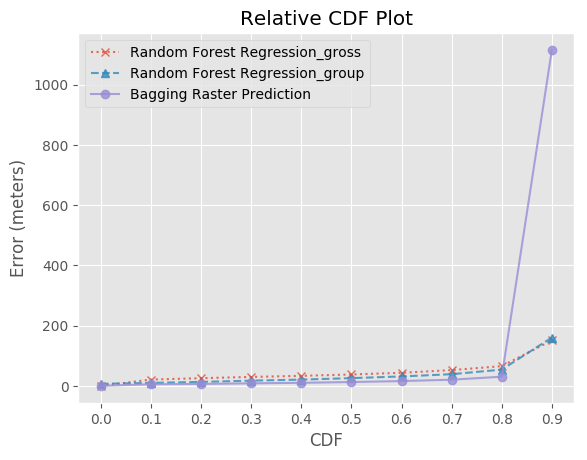

In [72]:
plt.style.use('ggplot')

xticks = np.arange(0, 1, 1 / down_sampling_count)
plt.xticks(xticks)

# total count
plt.plot(xticks, error, linestyle=':', marker='x', alpha=0.8)
# group sum
total_group_error = np.zeros(down_sampling_count)
for e in group_error:
    total_group_error += e
total_group_error /= len(group_error)
print('The average group CDF: ', total_group_error)
plt.plot(xticks, total_group_error, linestyle='--', marker='^', alpha=0.8)
# the method in Problem A
plt.plot(xticks, model_error['Bagging'], linestyle='-', marker='o', alpha=0.8)
    
plt.title('Relative CDF Plot')
plt.xlabel('CDF')
plt.ylabel('Error (meters)')
plt.legend(['Random Forest Regression_gross', 'Random Forest Regression_group','Bagging Raster Prediction'])
plt.savefig('Relative CDF.pdf')

# Problem D

对C题得到的分组结果进行排序，得到中位误差最小的`k`组，以及最大的`k`组（其中`k = 0.2 * K`, `K`为总共的分组数），将这些组的数据合在一起，完成C题的回归预测，比较结果。

In [249]:
k = round(len(data_group) * 0.2)
print(k)

9


In [250]:
mixed_groups = []
for i in range(k):
    mixed_groups.append([group_sorted[i]] + [group_sorted[-i-1]]) # merge the '+' and '-' pair
    
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

round_count = 10 
down_sampling_count = 10 # plot the result with 10 points
error_list = np.zeros(down_sampling_count)

for selected_group in mixed_groups:
    
    group_id = selected_group[0][1]
    group_index = data_group[group_id]
    X_train = new_X.iloc[group_index, :]
    Y_train = new_Y.iloc[group_index, :]
    
    group_id = selected_group[1][1]
    group_index = data_group[group_id]
    X_test = new_X.iloc[group_index, :]
    Y_test = new_Y.iloc[group_index, :]
    
    clf.fit(X_train, Y_train['delta_x'])
    Y_predict_lon = clf.predict(X_test) + Y_test['base_longitude']
    clf.fit(X_train, Y_train['delta_y'])
    Y_predict_lat = clf.predict(X_test) + Y_test['base_latitude']
    round_dist = func_dist(Y_test['Longitude'], Y_test['Latitude'], Y_predict_lon, Y_predict_lat)
    round_dist *= 1000  # unit: meters
    round_dist = np.sort(round_dist)
    down_samples = np.linspace(0, len(round_dist) - 1, down_sampling_count, dtype=int)
    error_list += np.asarray(round_dist.take(down_samples))
trans_learning = error_list / len(mixed_groups)

In [251]:
# conbine and sort
group_zip = zip([x[4] for x in group_error], list(data_group.keys()))
group_sorted = sorted(group_zip, key=lambda x: x[0])

mixed_groups = [group_sorted[:k] + group_sorted[-k:]] # merge all the groups
for i in range(k):
    mixed_groups.append([group_sorted[-i-1]]) # pure '-' class
for i in range(k):
    mixed_groups.append([group_sorted[i]] + [group_sorted[-i-1]]) # merge the '+' and '-' pair

In [252]:
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

round_count = 10 
down_sampling_count = 10 # plot the result with 10 points
error_list = []

for selected_group in mixed_groups:
    # merge the selected group
    merge_X = pd.DataFrame()
    merge_Y = pd.DataFrame()
    for item in selected_group:
        print(item)
        group_id = item[1]
        group_index = data_group[group_id]
        split_X = new_X.iloc[group_index, :]
        split_Y = new_Y.iloc[group_index, :]
        merge_X = merge_X.append(split_X)
        merge_Y = merge_Y.append(split_Y)
    
#     print(merge_X.describe())
#     print(merge_Y.describe())
    print(len(merge_X))
    # calculate the error
    round_error = np.zeros(down_sampling_count)
    for i in range(round_count):
        # partition the training and testing data randomly 
        X_train, X_test, Y_train, Y_test = train_test_split(merge_X, merge_Y, test_size=0.2)

        # fit and predict
        time_start = time.time()
        clf.fit(X_train, Y_train['delta_x'])
        Y_predict_lon = clf.predict(X_test) + Y_test['base_longitude']
        clf.fit(X_train, Y_train['delta_y'])
        Y_predict_lat = clf.predict(X_test) + Y_test['base_latitude']
        time_end = time.time()

        # calculate the distance
        round_dist = func_dist(Y_test['Longitude'], Y_test['Latitude'], Y_predict_lon, Y_predict_lat)
        round_dist *= 1000  # unit: meters
        round_dist = np.sort(round_dist)
#         print(round_dist[-10:])
        down_samples = np.linspace(0, len(round_dist) - 1, down_sampling_count, dtype=int)
        round_error += np.asarray(round_dist.take(down_samples))
    round_error /= round_count
    print(f"mid-error: {'%.2f' % round_error[4]}, worst-error: {'%.2f' % round_error[9]}, time: ({time_end - time_start:.2f}s)")
    error_list.append(round_error)

(0.0, (6188, 20865))
(0.0, (6188, 41123))
(5.695501516829938, (5198, 17029))
(8.340259688237975, (6188, 40957))
(8.584974003959637, (6188, 41149))
(10.290661998511268, (6188, 41124))
(10.883958234742904, (6188, 25089))
(11.512025335860068, (6182, 13698))
(11.636009469291842, (6188, 41076))
(28.47989167976142, (5198, 38198))
(28.874063765694302, (5198, 36811))
(29.36984598469047, (6182, 41139))
(30.940943403812884, (6188, 41092))
(31.422900309104307, (5198, 25312))
(31.959109958800838, (5198, 16059))
(32.75215195869903, (6188, 27377))
(33.67897118015547, (6188, 25105))
(48.56646822387733, (6188, 21331))
1886
mid-error: 45.73, worst-error: 1477.49, time: (1.85s)
(48.56646822387733, (6188, 21331))
8
mid-error: 38.65, worst-error: 71.49, time: (0.26s)
(33.67897118015547, (6188, 25105))
320
mid-error: 33.97, worst-error: 386.87, time: (0.42s)
(32.75215195869903, (6188, 27377))
136
mid-error: 28.90, worst-error: 198.39, time: (0.27s)
(31.959109958800838, (5198, 16059))
178
mid-error: 34.44, 

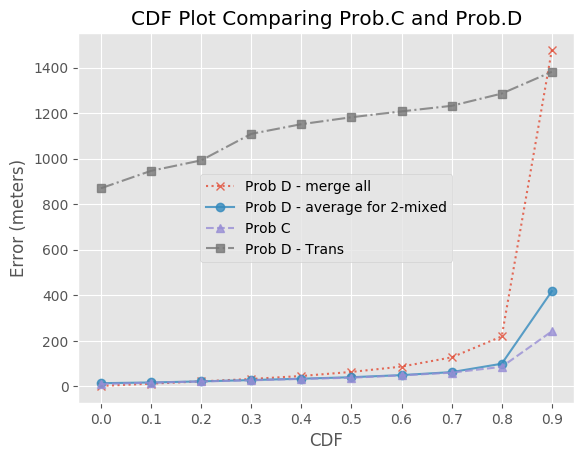

In [253]:
plt.style.use('ggplot')

xticks = np.arange(0, 1, 1 / down_sampling_count)
plt.xticks(xticks)

# total count
plt.plot(xticks, error_list[0], linestyle=':', marker='x', alpha=0.8)

prob_d = np.zeros(10)
for i in range(k+1, k+k+1):
    prob_d += error_list[i]
prob_d /= k
plt.plot(xticks, prob_d, linestyle='-', marker='o', alpha=0.8)

prob_c = np.zeros(10)
for i in range(1, k+1):
    prob_c += error_list[i]
prob_c /= k
plt.plot(xticks, prob_c, linestyle='--', marker='^', alpha=0.8)
plt.plot(xticks, trans_learning, linestyle='-.', marker='s', alpha=0.8)
    
plt.title('CDF Plot Comparing Prob.C and Prob.D')
plt.xlabel('CDF')
plt.ylabel('Error (meters)')
plt.legend([ 'Prob D - merge all', 'Prob D - average for 2-mixed', 'Prob C', 'Prob D - Trans'])
plt.savefig('Prob D.pdf')

# Problem E

In [187]:
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

RSSI_1 = new_X[['RSSI_1']]
sim_X = new_Y[['delta_x', 'delta_y']]
top_k_minus = group_sorted[-k:]
print(len(group_sorted))
error_list = []
for item in top_k_minus:
    group_id = item[1]
    group_index = data_group[group_id]
    X_1 = sim_X.iloc[group_index, :]
    Y_1 = RSSI_1.iloc[group_index]['RSSI_1']
    
    clf.fit(X_1, Y_1)
    
    # compute the similarity between groups
    simi_list = []
    for (RNCID, CellID), group_index_2 in data_group.items():
        if (RNCID, CellID) == group_id:
            print('yes')
            continue
        X_2 = sim_X.iloc[group_index_2, :]
        Y_2 = RSSI_1.iloc[group_index_2]['RSSI_1']
        P_2 = clf.predict(X_2)
       
        similarity = sum(abs(P_2 - Y_2))
        simi_list.append((similarity, (RNCID, CellID)))
    print(len(simi_list))
    simi_list = sorted(simi_list, key=lambda x:x[0])
    simi_max_id = simi_list[0][1]
    print(simi_max_id)
    
    # merge the group
    merge_X = new_X.iloc[group_index, :]
    merge_Y = new_Y.iloc[group_index, :]
    
    simi_index = data_group[simi_max_id]
    merge_X = merge_X.append(new_X.iloc[simi_index, :])
    merge_Y = merge_Y.append(new_Y.iloc[simi_index, :])

    # calculate the error
    round_count = 10 
    down_sampling_count = 10 # plot the result with 10 points
    round_error = np.zeros(down_sampling_count)
    for i in range(round_count):
        # partition the training and testing data randomly 
        X_train, X_test, Y_train, Y_test = train_test_split(merge_X, merge_Y, test_size=0.2)

        # fit and predict
        time_start = time.time()
        clf.fit(X_train, Y_train['delta_x'])
        Y_predict_lon = clf.predict(X_test) + Y_test['base_longitude']
        clf.fit(X_train, Y_train['delta_y'])
        Y_predict_lat = clf.predict(X_test) + Y_test['base_latitude']
        time_end = time.time()

        # calculate the distance
        round_dist = func_dist(Y_test['Longitude'], Y_test['Latitude'], Y_predict_lon, Y_predict_lat)
        round_dist *= 1000  # unit: meters
        round_dist = np.sort(round_dist)
        down_samples = np.linspace(0, len(round_dist) - 1, down_sampling_count, dtype=int)
        round_error += np.asarray(round_dist.take(down_samples))
    round_error /= round_count
    print(f"group-:{group_id} ; {simi_max_id} \n"
          f"mid-error: {'%.2f' % round_error[4]}," 
          f"worst-error: {'%.2f' % round_error[9]},"
          f"time: ({time_end - time_start:.2f}s)")
    error_list.append(round_error)

43
yes
42
(6188, 40957)
group-:(5198, 38198) ; (6188, 40957) 
mid-error: 28.41,worst-error: 129.34,time: (0.23s)
yes
42
(6188, 40957)
group-:(5198, 36811) ; (6188, 40957) 
mid-error: 23.29,worst-error: 112.96,time: (0.24s)
yes
42
(6188, 41146)
group-:(6182, 41139) ; (6188, 41146) 
mid-error: 50.84,worst-error: 572.80,time: (0.22s)
yes
42
(6188, 20865)
group-:(6188, 41092) ; (6188, 20865) 
mid-error: 31.34,worst-error: 570.59,time: (0.24s)
yes
42
(6188, 25089)
group-:(5198, 25312) ; (6188, 25089) 
mid-error: 34.56,worst-error: 454.87,time: (0.32s)
yes
42
(6188, 40957)
group-:(5198, 16059) ; (6188, 40957) 
mid-error: 33.09,worst-error: 369.23,time: (0.27s)
yes
42
(6188, 40957)
group-:(6188, 27377) ; (6188, 40957) 
mid-error: 31.59,worst-error: 187.72,time: (0.40s)
yes
42
(6188, 41146)
group-:(6188, 25105) ; (6188, 41146) 
mid-error: 32.53,worst-error: 400.22,time: (0.32s)
yes
42
(6188, 40957)
group-:(6188, 21331) ; (6188, 40957) 
mid-error: 68.52,worst-error: 137.06,time: (0.20s)


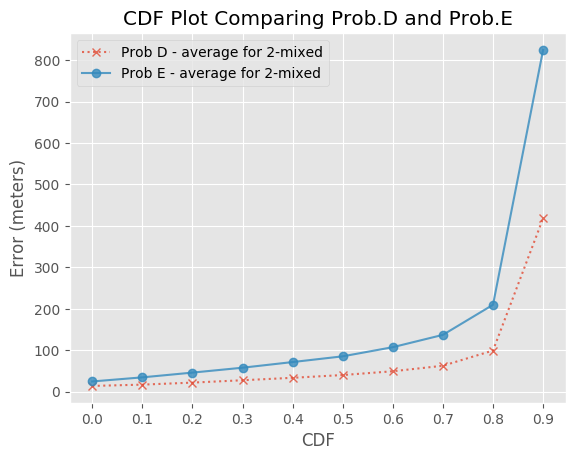

In [257]:
plt.style.use('ggplot')

xticks = np.arange(0, 1, 1 / down_sampling_count)
plt.xticks(xticks)

# total count
plt.plot(xticks, prob_d, linestyle=':', marker='x', alpha=0.8)
prob_e = sum(error_list)
prob_e /= k
plt.plot(xticks, prob_e, linestyle='-', marker='o', alpha=0.8)
    
plt.title('CDF Plot Comparing Prob.D and Prob.E')
plt.xlabel('CDF')
plt.ylabel('Error (meters)')
plt.legend([ 'Prob D - average for 2-mixed', 'Prob E - average for 2-mixed'])
plt.savefig('Prob E.pdf')